<div style="border: 2px solid #FF69B4; background-color: #000000; color: white; padding: 20px; border-radius: 5px;">

# Figure 7

Storylines: 2019 Heatwaves

---

 
---

</div>

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import regionmask
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as patches
from matplotlib import gridspec
from matplotlib.patches import FancyArrowPatch
from shapely.geometry import Polygon

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
def create_custom_colormap(colormap_file, reverse=False):
    """
    Create a custom colormap from an NCL colormap file.

    Parameters:
    - colormap_file (str): Path to the NCL colormap file.
    - reverse (bool): If True, reverse the colormap.

    Returns:
    - custom_cmap (LinearSegmentedColormap): Custom colormap object.
    """
    # Read the RGB values from the NCL colormap file
    rgb_values = np.loadtxt(colormap_file)

    # Find the largest digit in the file
    max_digit = np.max(rgb_values)

    # Scale RGB values by the largest digit
    rgb_values_scaled = rgb_values / max_digit

    # Optionally reverse the colormap
    if reverse:
        rgb_values_scaled = rgb_values_scaled[::-1]

    # Create the colormap
    custom_cmap = LinearSegmentedColormap.from_list("CustomColormap", rgb_values_scaled)

    return custom_cmap

In [3]:
rpath    = '/work/ab0995/a270229/work/data/paper1/story-nudged/data/events/HW/'
plotpath = '/work/ab0995/a270229/work/data/paper1/story-nudged/plot/hires/'

dc = xr.open_dataset(f'{rpath}cont/Paris/T2M_max_hrly_IFS-FESOM_20190725_TCO1279_EUR.nc')
dh = xr.open_dataset(f'{rpath}hist/Paris/T2M_max_hrly_IFS-FESOM_20190725_TCO1279_EUR.nc')
d2 = xr.open_dataset(f'{rpath}2k/Paris/T2M_max_hrly_IFS-FESOM_20190725_TCO1279_EUR.nc')

In [4]:
magc = dc['2t'][0,0,...]-273.15
magh = dh['2t'][0,0,...]-273.15
mag2 = d2['2t'][0,0,...]-273.15

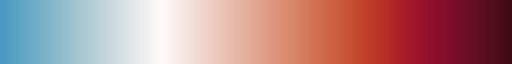

In [5]:
ncl_colormap_file = "/work/ab0995/a270229/work/misc/NCL_colortables/cmocean_balance_70bluereds.rgb"
cmap1 = create_custom_colormap(ncl_colormap_file,reverse=False)
cmap1

In [6]:
# Custom Mapbox tile provider
class MapboxTiles(cimgt.GoogleWTS):
    def __init__(self, access_token):
        self.access_token = access_token
        super().__init__(desired_tile_form='RGB')

    def _image_url(self, tile):
        x, y, z = tile
        url = (
            f"https://api.mapbox.com/styles/v1/amjohn001/clxube9ta00a701pa1jqx1vov/"
            f"tiles/256/{z}/{x}/{y}@2x?access_token={self.access_token}"
        )
        return url

# Mapbox access token
mapbox_access_token = 'pk.eyJ1IjoiYW1qb2huMDAxIiwiYSI6ImNsemI0YzN4cTAybjYya3M1N2R1Z3ZqbHYifQ.scte4U2UBYCcG0MyRquYyQ'
mapbox_tiles = MapboxTiles(access_token=mapbox_access_token)

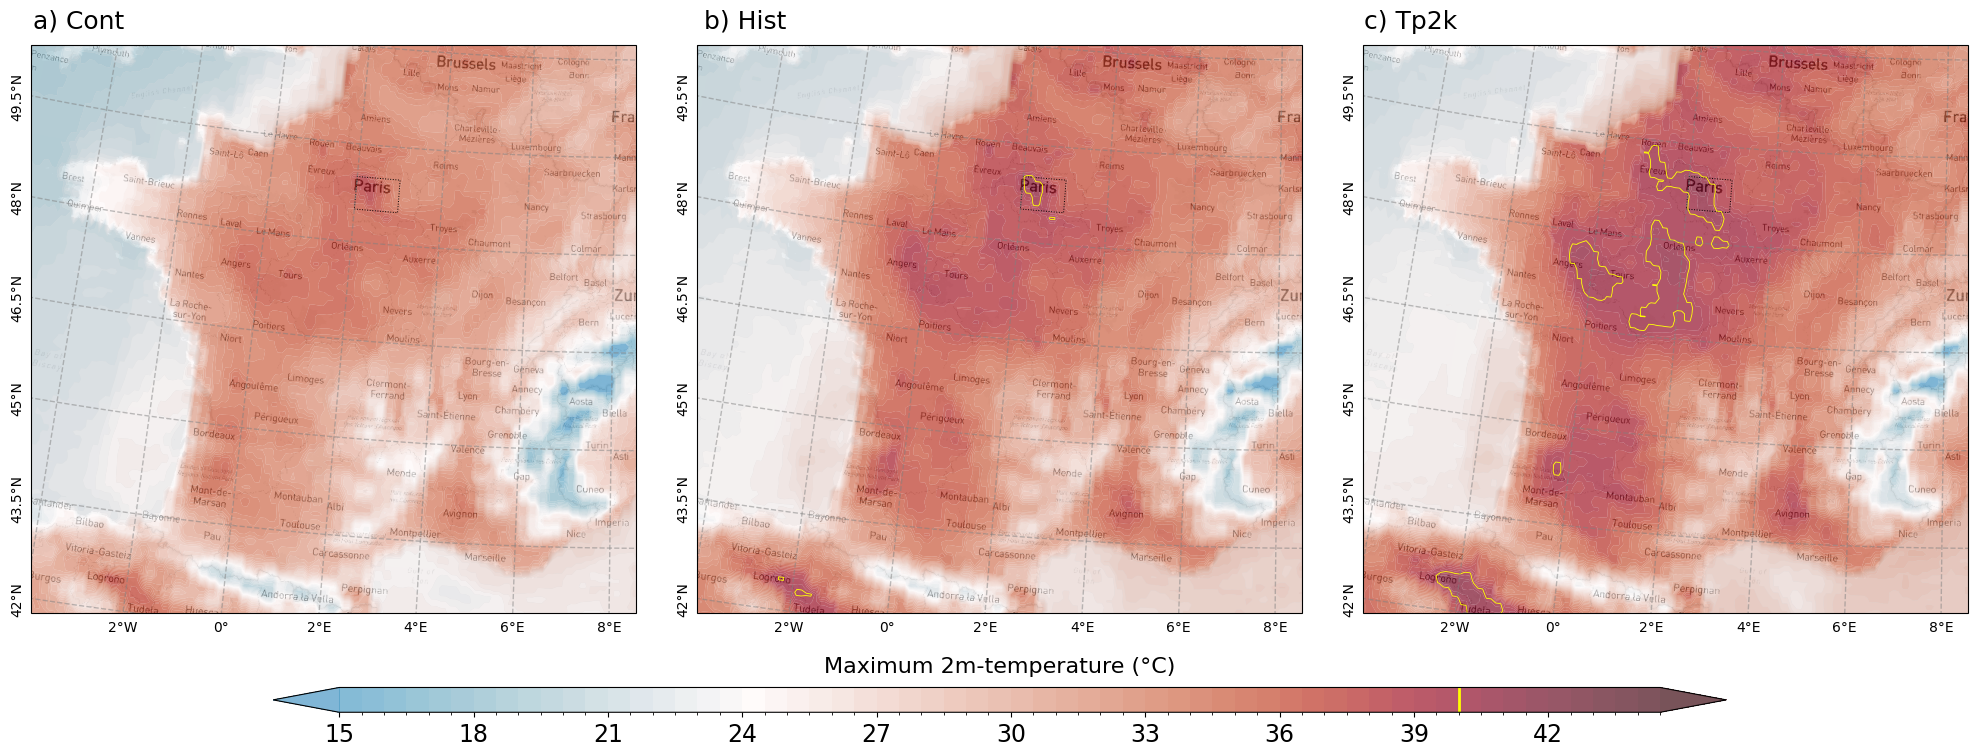

In [8]:
# --- Overall Figure Setup ---
fig = plt.figure(figsize=(25, 9))  # Wider figure for three sets
overall_grid = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.15, height_ratios=[1.0, 0.04])  # Space for colorbar

titles = ["ENS MEAN Cont", "ENS MEAN Hist", "ENS MEAN Tp2k"]

def create_layout_set(overall_grid_position, set_title):
    ax = fig.add_subplot(overall_grid_position, projection=ccrs.EuroPP())
    ax.set_aspect('equal')
    ax.annotate(set_title, xy=(0.079, 1.03), xycoords='axes fraction', ha='center', fontsize=18)
    return ax

# --- Define Europe region ---
europe_extent = [-4., 8.5, 42.5, 50.5]  # [min_lon, max_lon, min_lat, max_lat]

from matplotlib.colors import BoundaryNorm

def add_cartopy_plot(ax, data, extent):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Add the Mapbox tiles to your plot
    ax.add_image(mapbox_tiles, 7)
    
    # Define levels and colormap
    levels = np.arange(15, 45, 0.5)
    cmap = cmap1
    
    # Create BoundaryNorm with extended upper limit
    norm = BoundaryNorm(levels, ncolors=cmap.N, extend='both')
    
    # # Plot data with contourf
    contours = ax.contourf(data.lon, data.lat, data, 
                          transform=ccrs.PlateCarree(),
                          alpha=0.7, cmap=cmap, 
                          norm=norm,
                          levels=levels,
                          extend='both', antialiased=True)


    polygon_coords = [
    [2.0, 48.5],  # Bottom-left
    [3.0, 48.5],  # Bottom-right
    [3.0, 49.0],  # Top-right
    [2.0, 49.0],  # Top-left
    [2.0, 48.5]]  # Closing the polygon]
    
    ax.add_geometries([Polygon(polygon_coords)], crs=ccrs.PlateCarree(), 
                    facecolor='none', edgecolor='k', linewidth=0.7, linestyle=':')

    # Add black contour line for values > 125
    cs = ax.contour(data.lon, data.lat, data,
               transform=ccrs.PlateCarree(),
               levels=[40],
               colors='yellow',
               linewidths=0.6,
               linestyles='-')

    # Add gridlines and labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'rotation': 90}

    return contours

# --- Create the layout sets ---
ax_cont = create_layout_set(overall_grid[0, 0], 'a) Cont')
ax_hist = create_layout_set(overall_grid[0, 1], 'b) Hist')
ax_tp2k = create_layout_set(overall_grid[0, 2], 'c) Tp2k')

# Plot ensemble means
contour_cont = add_cartopy_plot(ax_cont, magc, europe_extent)
contour_hist = add_cartopy_plot(ax_hist, magh, europe_extent)
contour_tp2k = add_cartopy_plot(ax_tp2k, mag2, europe_extent)

# --- Add a common colorbar ---
colorbar_grid = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=overall_grid[1, :], wspace=0.0, width_ratios=[1, 6, 1])
ax_colorbar = fig.add_subplot(colorbar_grid[0, 1])

cbar = fig.colorbar(contour_cont, cax=ax_colorbar, orientation='horizontal', pad=0.2, shrink=0.7, extend='both')
cbar.set_label('Maximum 2m-temperature (°C)', fontsize=16, labelpad=-65)
cbar.ax.tick_params(labelsize=17) 
cbar.ax.axvline(x=40, color='yellow', linestyle='-', linewidth=2)

# --- Show the plot ---
# plt.savefig(f"{plotpath}F7_a.png", dpi=500, bbox_inches='tight')
plt.show()


<div style="border: 2px solid #00ff40; background-color: #000000; color: white; padding: 20px; border-radius: 5px;">

2m-temperature hourly evolution over Paris

---
---
  
</div>

In [9]:
dc= xr.open_dataset('/work/ab0995/a270229/work/data/paper1/story-nudged/data/events/HW/cont/Paris/T2M_max_hrly_IFS-FESOM_20190725_TCO1279_Paris-.nc')
dh= xr.open_dataset('/work/ab0995/a270229/work/data/paper1/story-nudged/data/events/HW/hist/Paris/T2M_max_hrly_IFS-FESOM_20190725_TCO1279_Paris-.nc')
d2= xr.open_dataset('/work/ab0995/a270229/work/data/paper1/story-nudged/data/events/HW/2k/Paris/T2M_max_hrly_IFS-FESOM_20190725_TCO1279_Paris-.nc')

In [10]:
c=dc['2t'].isel(height=0).drop_vars('height')-273.15
h=dh['2t'].isel(height=0).drop_vars('height')-273.15
f=d2['2t'].isel(height=0).drop_vars('height')-273.15

In [11]:
cont_series = c.max(dim=['lat', 'lon']).to_series()
hist_series = h.max(dim=['lat', 'lon']).to_series()
tp2k_series = f.max(dim=['lat', 'lon']).to_series()


# Create a pandas DataFrame from the Series
df = pd.DataFrame({
    'Tp2K': tp2k_series,
    'Hist': hist_series,
    'Cont': cont_series
})

# Filter the DataFrame to only include data between 2019-07-14 00:00 and 2019-07-15 22:00
start_time = pd.Timestamp('2019-07-25 00:00')
end_time = pd.Timestamp('2019-07-25 23:00')
df_filtered = df[start_time:end_time]

In [12]:
df.where(df > 40).max()

Tp2K    41.306488
Hist    40.911591
Cont          NaN
dtype: float32

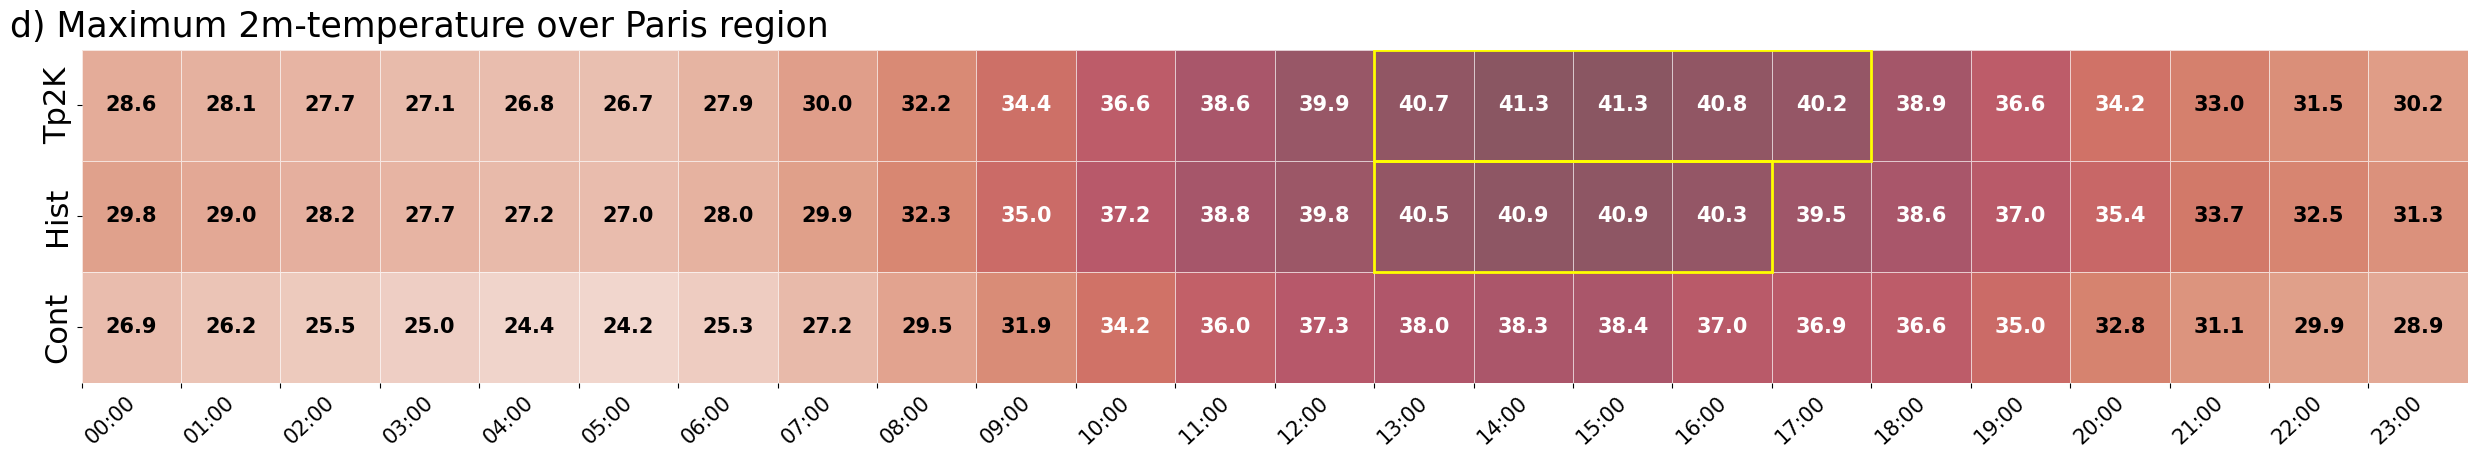

In [14]:

# Example time labels (replace with your actual time data)
time_labels = ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', 
               '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', 
               '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']

y_labels = ['Cont', 'Hist', 'Tp2K']

# highlights = {
#     0: [(11, 18)],        # Highlight columns 2 to 5 in row 1 (0-based index)
#     1: [(11, 18)],        # Highlight columns 5 and 6 in row 2
#     2: [(13, 15)]        # Highlight columns 8 to 10 in row 3
# }

highlights = {
    0: [(13, 17)],        # Highlight columns 2 to 5 in row 1 (0-based index)
    1: [(13, 16)],        # Highlight columns 5 and 6 in row 2
           # Highlight columns 8 to 10 in row 3
}


# Create the heatmap
plt.figure(figsize=(25, 5))  

ax = sns.heatmap(df_filtered.T, annot=True, cmap=cmap1, linewidths=0.5, fmt=".1f", 
                 cbar=False, annot_kws={"size": 15, "weight": "bold"}, vmax=43, vmin=10, alpha=0.7)  # Remove fixed color parameter; add "weight": "bold"

# Get colormap and normalization from heatmap
cmap = ax.collections[0].cmap
norm = ax.collections[0].norm

# Calculate text colors based on cell luminance
for text, val in zip(ax.texts, df_filtered.T.values.flatten()):
    rgba = cmap(norm(val))
    luminance = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
    text.set_color('white' if luminance < 0.37 else 'black')

# Set the x-axis labels to the time labels
plt.xticks(ticks=range(len(time_labels)), labels=time_labels, rotation=43, fontsize=15, ha='left')  # Rotate x-axis labels, right alignment
plt.yticks(rotation=90, fontsize=22)                # Keep y-axis labels horizontal with larger font

# Customize the plot
plt.xlabel('Hour of the day', fontsize=25, labelpad=15)   # Increased font size for x-label
plt.xlabel('', fontsize=30, labelpad=15)

for row, ranges in highlights.items():
    for (start_col, end_col) in ranges:
        # Create a single rectangle that spans from start_col to end_col
        ax.add_patch(patches.Rectangle((start_col, row), end_col - start_col + 1, 1, 
                                       fill=False, edgecolor='yellow', lw=2, linestyle='-'))  # Use dashed lines for highlighting


ax.text(-0.03, 1.12, 'd) Maximum 2m-temperature over Paris region', transform=ax.transAxes, fontsize=25, va='top', ha='left')
# Adjust layout
plt.tight_layout(pad=2)  # Additional padding to ensure elements are properly spaced

# plt.savefig(f"{plotpath}F7_b.png", dpi=400, bbox_inches='tight')

plt.show()
